In [8]:
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
DATA_PATH = "data.json"
SAVED_MODEL_PATH = "model.h5"
EPOCHS = 40
BATCH_SIZE = 32
PATIENCE = 5
LEARNING_RATE = 0.0001

In [3]:

def load_data(data_path):

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["MFCCs"])
    y = np.array(data["labels"])
    print("Training sets loaded!")
    return X, y



In [4]:
def prepare_dataset(data_path, test_size=0.2, validation_size=0.2):
    # load dataset
    X, y = load_data(data_path)

    # create train, validation, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to nd array
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]

    return X_train, y_train, X_validation, y_validation, X_test, y_test




In [5]:
def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()

    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape,
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    tf.keras.layers.Dropout(0.3)

    # softmax output layer
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])

    # print model parameters on console
    model.summary()

    return model


In [6]:
def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)

    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history


In [7]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create loss subplot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")

    plt.show()

Training sets loaded!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 42, 11, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 42, 11, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 6, 64)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 4, 32)         18464     
                                                                 
 batch_normalization_1 (Batc  (None, 19, 4, 32)        128       
 hNormalization)                                                 
                                  

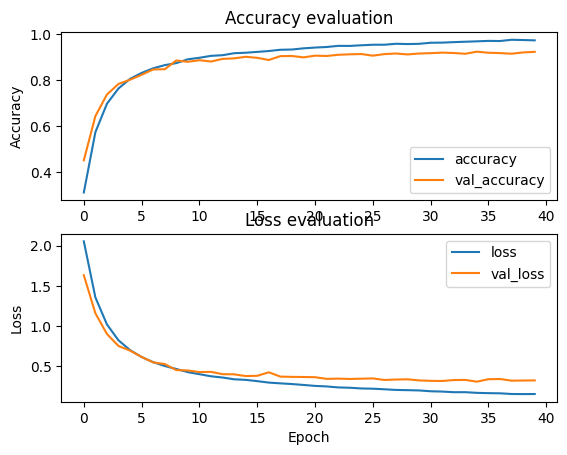

134/134 [==============================] - 1s 5ms/step - loss: 0.3599 - accuracy: 0.9087

Test loss: 0.35992559790611267, test accuracy: 90.87496995925903


In [8]:
def main():
    # generate train, validation and test sets
    X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(DATA_PATH)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape, learning_rate=LEARNING_RATE)

    # train network
    history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)

    # plot accuracy/loss for training/validation set as a function of the epochs
    plot_history(history)

    # evaluate network on test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

    # save model
    model.save(SAVED_MODEL_PATH)


if __name__ == "__main__":
    main()

In [4]:

import pyaudio
import wave
CHUNK = 2048
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 22050
WAVE_OUTPUT_FILENAME = "file.wav"
audio = pyaudio.PyAudio()
# start Recording
stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True,
                frames_per_buffer=CHUNK)
print("recording...")
frames = []
#stop recording when there is keyboard interrupt
try:
    while True:
        data = stream.read(CHUNK)
        frames.append(data)
except KeyboardInterrupt:
    pass

print("finished recording")
# stop Recording
stream.stop_stream()
stream.close()
audio.terminate()
waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(audio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(frames))
waveFile.close()


recording...
finished recording


In [5]:
SAMPLES_TO_CONSIDER = 22050 # 1 sec. of audio
num_mfcc=13
n_fft=2048
hop_length=512
WAVE_OUTPUT_FILENAME = "file.wav"

In [6]:
data=["down","go","left","no","off","on","right","stop","up","yes" ]
data_aug= ["bed","bird","cat","dog","happy","house","one","tree","wow","zero"]

In [7]:
from tensorflow.keras.models import load_model
model = load_model(r"C:\Users\saket\Desktop\xwebsite\ML\AI\model.h5")
model_aug = load_model(r"C:\Users\saket\Desktop\xwebsite\ML\AI\model_aug.h5")

In [8]:
import librosa
import numpy as np
signal, sample_rate = librosa.load(WAVE_OUTPUT_FILENAME)

if len(signal) >= SAMPLES_TO_CONSIDER:
    signal = signal[:SAMPLES_TO_CONSIDER]
    MFCCs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,
                                    hop_length=hop_length)
    X=np.array(MFCCs.T.tolist())
    X=X[..., np.newaxis]
    X=X.reshape(-1,44,13,1)
    MFCC_index=model.predict(X)
    print(data[np.argmax(MFCC_index)])
    # MFCC_index=model_aug.predict(X)
    # print(data_aug[np.argmax(MFCC_index)])

1/1 [==============================] - 30s 30s/step
left
